In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, brier_score_loss
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

In [3]:
data = pd.read_csv('data/model_data.csv')

In [4]:
len(data['pitcher'].unique())

198

# Modeling

Feature Selection

In [5]:
log_reg_df = data[['pitch_type', 'GameDate', 'pitcher', 'batter', 'ab', 'pitchnum', 
       'Count_0_1', 'Count_0_2', 'Count_2_1',
       'Count_1_0', 'Count_1_1', 'Count_1_2', 'Count_2_0', 'Count_2_2', 'Count_3_1',
       'Count_3_0', 'batter_count', 'pitcher_count']].copy()
log_reg_df['neutral_count'] = ((log_reg_df['batter_count'] == 0) & (log_reg_df['pitcher_count']== 0)).astype(int)

Player-Specific Features and train/test split

In [6]:
print(f"batter count mean fastball rate {log_reg_df[log_reg_df['batter_count'] == 1.0]['pitch_type'].mean()}")
print(f"pitcher count mean fastball rate {log_reg_df[log_reg_df['pitcher_count'] == 1.0]['pitch_type'].mean()}")
print(f"neutral count mean fastball rate {log_reg_df[log_reg_df['neutral_count'] == 1.0]['pitch_type'].mean()}")

size = 50 #how much shrinkage we want to apply

#Shrinkage terms match overall rates we want to regress to
batter_count_sum = 49/size
batter_count_tot = 100/size

pitcher_count_sum = 80/size
pitcher_count_tot = 100/size

neutral_count_sum = 60/size
neutral_count_tot = 100/size

batter count mean fastball rate 0.80156054330026
pitcher count mean fastball rate 0.4922912205567452
neutral count mean fastball rate 0.6018016945453102


In [7]:
def calculate_rate(df, group_by_col, condition=None, prior_sum=0, prior_count=0, sum_col='sum', count_col='count', suffix=''):
    filtered_df = df.query(condition)
    rate_df = filtered_df.groupby(group_by_col)['pitch_type'].agg([sum_col, count_col]).reset_index()
    rate_df[sum_col] += prior_sum
    rate_df[count_col] += prior_count
    rate_df = rate_df.rename(columns={sum_col: f'{group_by_col}_{suffix}_sum', count_col: f'{group_by_col}_{suffix}_tot'})
    rate_df[f'{group_by_col}_fb_rate_{suffix}'] = rate_df[f'{group_by_col}_{suffix}_sum'] / rate_df[f'{group_by_col}_{suffix}_tot']
    return rate_df

# Filter data
train = log_reg_df[log_reg_df['GameDate'] < '2023-06-15']
historical_rates = train.copy()

# Naive historical rates
naive_historical_rates = historical_rates.groupby('pitcher')['pitch_type'].agg(['sum', 'count']).reset_index()
naive_historical_rates['naive_historical_rate'] = naive_historical_rates['sum'] / naive_historical_rates['count']
naive_historical_rates = naive_historical_rates[['pitcher', 'naive_historical_rate']]

# Calculate rates for pitcher and batter under different count conditions

conditions = {
    'batter_count': "batter_count == 1.0",
    'pitcher_count': "pitcher_count == 1.0",
    'neutral_count': 'neutral_count == 1.0'
}

# Calculate pitcher rates
pitcher_rates = [
    calculate_rate(historical_rates, 'pitcher', condition, pitcher_count_sum, pitcher_count_tot, suffix=key) for key, condition in conditions.items()
]

# Calculate batter rates
batter_rates = [
    calculate_rate(historical_rates, 'batter', condition, batter_count_sum, batter_count_tot, suffix=key) for key, condition in conditions.items()
]

# Merge calculated rates
for rate_df in pitcher_rates + [naive_historical_rates]:
    train = train.merge(rate_df, on='pitcher')

for rate_df in batter_rates:
    train = train.merge(rate_df, on='batter')

# Keep necessary columns
columns_to_keep = ['Count_0_1', 'Count_0_2', 'Count_2_1', 'Count_1_0', 'Count_1_1',
       'Count_1_2', 'Count_2_0', 'Count_2_2', 'Count_3_1', 'Count_3_0', 'pitcher_fb_rate_batter_count',
       'pitcher_fb_rate_pitcher_count', 'pitcher_fb_rate_neutral_count', 'batter_fb_rate_batter_count',
       'batter_fb_rate_pitcher_count', 'batter_fb_rate_neutral_count', 'batter_count', 'neutral_count', 'pitcher_count']
X_train = train[columns_to_keep]
feature_names = X_train.columns
y_train = train[['pitch_type']]

In [8]:
def merge_rates(test_df, rate_dfs, merge_on):
    for rate_df in rate_dfs:
        if merge_on in rate_df.columns:
            test_df = test_df.merge(rate_df, on=merge_on, how='left')
    return test_df

test = log_reg_df[log_reg_df['GameDate'] >= '2023-06-15'] #~19% of data after this date

# Combine rate information from train set into test
rate_dfs = pitcher_rates + batter_rates + [naive_historical_rates]
test = merge_rates(test, rate_dfs, merge_on='pitcher')
test = merge_rates(test, batter_rates, merge_on='batter')

# Fill pitchers who don't have any data in the train set with averages 
test.fillna({
    'pitcher_batter_count_tot': batter_count_tot, 'pitcher_batter_count_sum': batter_count_sum, 
    'pitcher_pitcher_count_tot': pitcher_count_tot, 'pitcher_pitcher_count_sum': pitcher_count_sum, 
    'pitcher_neutral_count_tot': neutral_count_tot, 'pitcher_neutral_count_sum': neutral_count_sum, 
    'batter_batter_count_tot': batter_count_tot, 'batter_batter_count_sum': batter_count_sum, 
    'batter_pitcher_count_sum': pitcher_count_tot, 'batter_pitcher_count_tot': pitcher_count_sum,
    'batter_neutral_count_tot': neutral_count_tot, 'batter_neutral_count_sum': neutral_count_sum
    
}, inplace=True)

# Sort data to perform cummalative counts
test = test.sort_values(['pitcher', 'GameDate', 'ab', 'pitchnum']).reset_index(drop=True)

# Perform cummalative sums and totals for each pitcher, for each type of count, to update the rates as the test set goes on
test['pitcher_cumsum_b'] = test.groupby('pitcher').apply(lambda x: np.cumsum((x['pitch_type']==1) & (x['batter_count'] == 1), 0)).reset_index(drop=True)
test['pitcher_cumsum_p'] = test.groupby('pitcher').apply(lambda x: np.cumsum((x['pitch_type']==1) & (x['pitcher_count'] == 1), 0)).reset_index(drop=True)
test['batter_cumsum_b'] = test.groupby('batter').apply(lambda x: np.cumsum((x['pitch_type']==1) & (x['batter_count'] == 1), 0)).reset_index(drop=True)
test['batter_cumsum_p'] = test.groupby('batter').apply(lambda x: np.cumsum((x['pitch_type']==1) & (x['pitcher_count'] == 1), 0)).reset_index(drop=True)
test['pitcher_cumsum_n'] = test.groupby('pitcher').apply(lambda x: np.cumsum((x['pitch_type']==1) & (x['neutral_count']== 1), 0)).reset_index(drop=True)
test['batter_cumsum_n'] = test.groupby('batter').apply(lambda x: np.cumsum((x['pitch_type']==1) & (x['neutral_count']== 1), 0)).reset_index(drop=True)

test['pitcher_cumcount_b'] = test.groupby('pitcher').apply(lambda x: np.cumsum((x['batter_count'] == 1), 0)).reset_index(drop=True)
test['pitcher_cumcount_p'] = test.groupby('pitcher').apply(lambda x: np.cumsum((x['pitcher_count'] == 1), 0)).reset_index(drop=True)
test['batter_cumcount_b'] = test.groupby('batter').apply(lambda x: np.cumsum((x['batter_count'] == 1), 0)).reset_index(drop=True)
test['batter_cumcount_p'] = test.groupby('batter').apply(lambda x: np.cumsum((x['pitcher_count'] == 1), 0)).reset_index(drop=True)
test['pitcher_cumcount_n'] = test.groupby('pitcher').apply(lambda x: np.cumsum((x['neutral_count']== 1), 0)).reset_index(drop=True)
test['batter_cumcount_n'] = test.groupby('batter').apply(lambda x: np.cumsum((x['neutral_count']== 1), 0)).reset_index(drop=True)

# Update the totals with this new information
test['pitcher_batter_count_tot'] = test['pitcher_batter_count_tot'] + test['pitcher_cumcount_b'] 
test['pitcher_pitcher_count_tot'] = test['pitcher_pitcher_count_tot'] + test['pitcher_cumcount_p']
test['pitcher_batter_count_sum'] = test['pitcher_batter_count_sum'] + test['pitcher_cumsum_b']
test['pitcher_pitcher_count_sum'] = test['pitcher_pitcher_count_sum'] + test['pitcher_cumsum_p']
test['pitcher_neutral_count_sum'] = test['pitcher_neutral_count_sum'] + test['pitcher_cumsum_n']
test['pitcher_neutral_count_tot'] = test['pitcher_neutral_count_tot'] + test['pitcher_cumcount_n']

test['batter_batter_count_tot'] = test['batter_batter_count_tot'] + test['batter_cumcount_b']
test['batter_pitcher_count_tot'] = test['batter_pitcher_count_tot'] + test['batter_cumcount_p']
test['batter_batter_count_sum'] = test['batter_batter_count_sum'] + test['batter_cumsum_b']
test['batter_pitcher_count_sum'] = test['batter_pitcher_count_sum'] + test['batter_cumsum_p']
test['batter_neutral_count_sum'] = test['batter_neutral_count_sum'] + test['batter_cumsum_n']
test['batter_neutral_count_tot'] = test['batter_neutral_count_tot'] + test['batter_cumcount_n']

# Recalculate rates at each step
test['pitcher_fb_rate_batter_count'] = test['pitcher_batter_count_sum'] / test['pitcher_batter_count_tot']
test['pitcher_fb_rate_pitcher_count'] = test['pitcher_pitcher_count_sum'] / test['pitcher_pitcher_count_tot']
test['batter_fb_rate_batter_count'] = test['batter_batter_count_sum'] / test['batter_batter_count_tot']
test['batter_fb_rate_pitcher_count'] = test['batter_pitcher_count_sum'] / test['batter_pitcher_count_tot']
test['batter_fb_rate_neutral_count'] = test['batter_neutral_count_sum'] / test['batter_neutral_count_tot']
test['pitcher_fb_rate_neutral_count'] = test['pitcher_neutral_count_sum'] / test['pitcher_neutral_count_tot']

X_test = test[columns_to_keep]
y_test = test[['pitch_type']]

C:\Users\johng\AppData\Local\Temp\ipykernel_5872\139021506.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test['pitcher_cumsum_b'] = test.groupby('pitcher').apply(lambda x: np.cumsum((x['pitch_type']==1) & (x['batter_count'] == 1), 0)).reset_index(drop=True)
C:\Users\johng\AppData\Local\Temp\ipykernel_5872\139021506.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test['pitcher_cumsum_p'] = test.g

Save to csv to pass to R to expirement with random effects

In [ ]:
#train.to_csv('train_data.csv', index=False) 
#test.to_csv('test_data.csv', index=False)

In [10]:
#Upon fixing the error with updating rates, only pitcher rates improve AUC score, not batter rates

# Create Aggregate rate column that produces the correct rate based on the count
X_train['pitcher_rate'] = X_train['pitcher_fb_rate_pitcher_count'] * X_train['pitcher_count'] +\
X_train['pitcher_fb_rate_batter_count'] * X_train['batter_count'] +\
X_train['pitcher_fb_rate_neutral_count'] * X_train['neutral_count']

X_test['pitcher_rate'] = X_test['pitcher_fb_rate_pitcher_count'] * X_test['pitcher_count'] +\
X_test['pitcher_fb_rate_batter_count'] * X_test['batter_count'] +\
X_test['pitcher_fb_rate_neutral_count'] * X_test['neutral_count']


X_train = X_train.drop(['pitcher_fb_rate_batter_count', 'pitcher_fb_rate_pitcher_count',
       'pitcher_fb_rate_neutral_count', 'batter_fb_rate_batter_count',
       'batter_fb_rate_pitcher_count', 'batter_fb_rate_neutral_count',
       'batter_count', 'neutral_count', 'pitcher_count'], axis = 1)

X_test = X_test.drop([
       'pitcher_fb_rate_batter_count', 'pitcher_fb_rate_pitcher_count',
       'pitcher_fb_rate_neutral_count', 'batter_fb_rate_batter_count',
       'batter_fb_rate_pitcher_count', 'batter_fb_rate_neutral_count',
       'batter_count', 'neutral_count', 'pitcher_count'], axis = 1)



C:\Users\johng\AppData\Local\Temp\ipykernel_5872\1328065190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pitcher_rate'] = X_train['pitcher_fb_rate_pitcher_count'] * X_train['pitcher_count'] +\
C:\Users\johng\AppData\Local\Temp\ipykernel_5872\1328065190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pitcher_rate'] = X_test['pitcher_fb_rate_pitcher_count'] * X_test['pitcher_count'] +\


Train Lin Reg Model and make prediction on Test set (and create naive predictions)

In [11]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


# Create and fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

print(result.summary())
# Predict on the test set
y_plot = result.predict(X_train)
y_pred_prob = result.predict(X_test)
y_train_pred = (y_plot >= 0.5).astype(int)
y_pred = (y_pred_prob >= 0.5).astype(int)

naive_prob = test['naive_historical_rate'].values
naive_prob[np.isnan(naive_prob)] = np.nanmean(naive_prob)
y_pred_naive = (naive_prob >= 0.5).astype(int)

Optimization terminated successfully.
         Current function value: 0.589646
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             pitch_type   No. Observations:               117243
Model:                          Logit   Df Residuals:                   117231
Method:                           MLE   Df Model:                           11
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.1291
Time:                        10:35:46   Log-Likelihood:                -69132.
converged:                       True   LL-Null:                       -79377.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.4804      0.028    -90.035      0.000      -2.534      -2.426
Count_0_1       -0.2538

Results from Random Effects

In [12]:
#y_random_prob = pd.read_csv("predicted_probs.csv")['x']
#y_pred2 = (y_random_prob > 0.5).astype('int')

# Model Evaluation / Results

In [13]:
result_df = pd.concat([test['pitcher'], X_test, pd.Series(y_pred), y_test], axis=1)
result_df = result_df.rename({0:'pred_pitch'}, axis=1)
result_df['pred_prob'] = y_pred_prob
#result_df['pred_prob_rand'] = y_random_prob
#result_df['y_pred_rand'] = y_pred2

Scores

In [14]:
our_model = round(brier_score_loss(y_test, y_pred_prob), 4)
naive_model = round(brier_score_loss(y_test, naive_prob), 3)

print(f'Our model has a brier score of {our_model} and the naive model has a score of {naive_model}')

Our model has a brier score of 0.2067 and the naive model has a score of 0.222


In [15]:
our_model = round(roc_auc_score(y_test, y_pred_prob), 3)
naive_model = round(roc_auc_score(y_test, naive_prob), 3)

print(f'Our model has a auc score of {our_model} and the naive model has a score of {naive_model}')

Our model has a auc score of 0.724 and the naive model has a score of 0.66


Confusion Matrix

In [16]:
from sklearn import metrics
from sklearn.metrics import classification_report

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
target_names = ['breaking ball', 'fastball']
print(classification_report(y_test, y_pred, target_names=target_names))
cnf_matrix

               precision    recall  f1-score   support

breaking ball       0.60      0.52      0.56     11749
     fastball       0.69      0.75      0.72     16442

     accuracy                           0.66     28191
    macro avg       0.64      0.64      0.64     28191
 weighted avg       0.65      0.66      0.65     28191



array([[ 6125,  5624],
       [ 4080, 12362]], dtype=int64)

In [17]:
i_cnf_matrix = np.array([[cnf_matrix[1, 1], cnf_matrix[1, 0]],
                                [cnf_matrix[0, 1], cnf_matrix[0, 0]]])

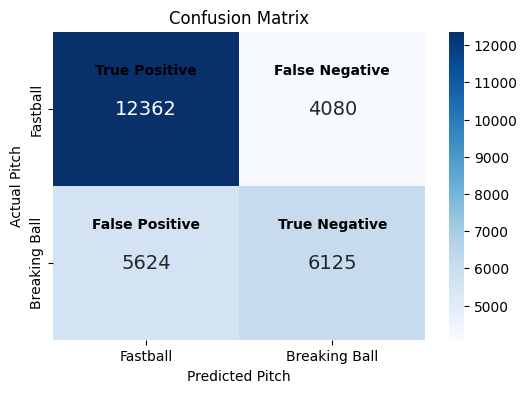

In [18]:
labels = np.array([["True Positive", "False Negative"],
                   ["False Positive", "True Negative"]])

plt.figure(figsize=(6, 4))
plt.title("Confusion Matrix")
ax = sns.heatmap(i_cnf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fastball', 'Breaking Ball'], yticklabels=[ 'Fastball', 'Breaking Ball']
, annot_kws={"size": 14})
plt.xlabel('Predicted Pitch')
plt.ylabel('Actual Pitch')

for i in range(2):
    for j in range(2):
        ax.text(j + 0.5, i + 0.25, f"{labels[i, j]}", color="black", ha="center", va="center", fontsize=10, weight='bold')

plt.show()

ROC Curve

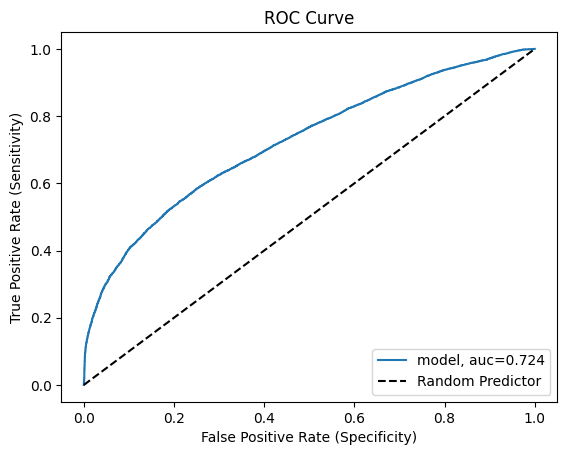

In [19]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="model, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Predictor')
plt.legend(loc=4)
plt.title("ROC Curve")
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

Calibration

In [20]:
result_df['prob_bin'] = pd.cut(result_df['pred_prob'], np.linspace(0, 1, 11))

C:\Users\johng\AppData\Local\Temp\ipykernel_5872\2295090214.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = result_df.groupby('prob_bin').agg(


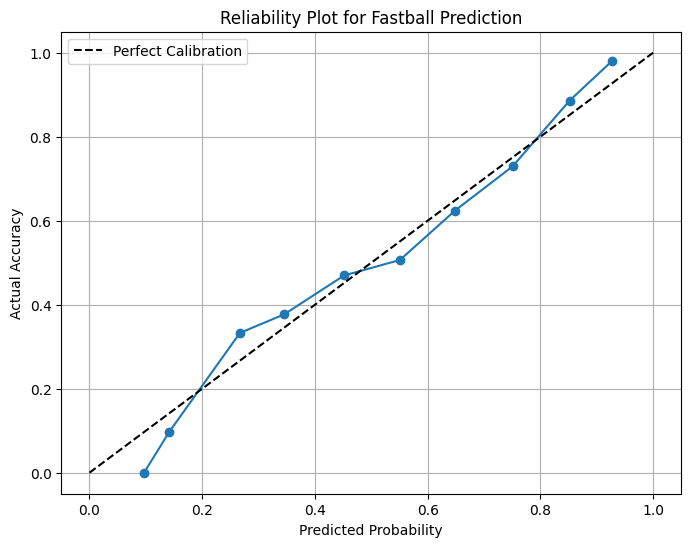

In [21]:
bin_summary = result_df.groupby('prob_bin').agg(
    avg_pred_prob=('pred_prob', 'mean'),  
    actual_accuracy=('pitch_type', 'mean') 
).dropna() 
plt.figure(figsize=(8, 6))
plt.plot(bin_summary['avg_pred_prob'], bin_summary['actual_accuracy'], marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

plt.xlabel('Predicted Probability')
plt.ylabel('Actual Accuracy')
plt.title('Reliability Plot for Fastball Prediction')
plt.legend()
plt.grid()
plt.show()

In [22]:
bin_summary

,avg_pred_prob,actual_accuracy
prob_bin,,
"(0.0, 0.1]",0.096811,0.000000
"(0.1, 0.2]",0.141978,0.098101
"(0.2, 0.3]",0.267041,0.332907
"(0.3, 0.4]",0.345295,0.376917
"(0.4, 0.5]",0.451896,0.469765
"(0.5, 0.6]",0.550736,0.506429
"(0.6, 0.7]",0.648745,0.624316
"(0.7, 0.8]",0.750923,0.729612
"(0.8, 0.9]",0.851831,0.885946


Final list

In [23]:
result_df.loc[result_df['pred_pitch'] == result_df['pitch_type'], 'correct'] = 1.0
result_df['correct'] = result_df['correct'].fillna(0.0)

In [24]:
final_list = result_df.groupby('pitcher')['correct'].agg(['mean', 'count']).reset_index()

In [25]:
final_list_sample = final_list.loc[final_list['count'] > 75]

In [26]:
final_list_sample.set_index('pitcher')[['mean']].sort_values('mean').head(10)

,mean
pitcher,
"Romano, Jordan",0.430928
"Coleman, Dylan",0.465201
"Diaz, Alexis",0.479224
"Anderson, Nick",0.489510
"Munoz, Andres",0.501323
"Karinchak, James",0.508403
"Herrin, Tim",0.514493
"Campbell, Isaiah",0.527197
"Brigham, Jeff",0.528571


In [27]:
final_list_sample.set_index('pitcher')[['mean']].sort_values('mean', ascending=False).head(10)

,mean
pitcher,
"Alvarado, Jose",0.997881
"Hudson, Bryan",0.963415
"Ferguson, Caleb",0.956800
"Armstrong, Shawn",0.935574
"Koch, Matt",0.916096
"Adams, Austin",0.900826
"Stratton, Hunter",0.885057
"Jansen, Kenley",0.864458
"Doyle, Tommy",0.863636


Making Predictions

In [28]:
Count = '0-0'
pitcher = 'Adcock, Ty'

In [29]:
def create_prediction_arr(count, pitcher):
    pred_arr = np.zeros(13)
    pred_arr[0] = 1
    if count == '0-1': pred_arr[1] = 1
    if count == '0-2': pred_arr[2] = 1
    if count == '2-1': pred_arr[3] = 1
    if count == '1-0': pred_arr[4] = 1
    if count == '1-1': pred_arr[5] = 1
    if count == '1-2': pred_arr[6] = 1
    if count == '2-0': pred_arr[7] = 1
    if count == '2-2': pred_arr[8] = 1
    if count == '3-1': pred_arr[9] = 1
    if count == '3-0': pred_arr[10] = 1
    pitcher_rate_b_count = train[train['pitcher'] == pitcher]['pitcher_fb_rate_batter_count']
    pitcher_rate_p_count = train[train['pitcher'] == pitcher]['pitcher_fb_rate_pitcher_count']
    if len(pitcher_rate_b_count) != 0: pred_arr[11] = pitcher_rate_b_count.iloc[0]
    else: pred_arr[11] = 0.80
    if len(pitcher_rate_p_count) != 0 : pred_arr[12] = pitcher_rate_p_count.iloc[0]
    else: pred_arr[12] = 0.49

    return pred_arr
    

In [30]:
test = create_prediction_arr(Count, pitcher)

In [31]:
test

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.86666667, 0.94285714])

In [32]:
result.predict(test)

ValueError: shapes (1,13) and (12,) not aligned: 13 (dim 1) != 12 (dim 0)